In [44]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.path import Path  # For point-in-polygon test
from matplotlib.patches import PathPatch  # For drawing patches
from skimage.draw import polygon2mask

In [45]:
def load_dicom_series_to_hu(dicom_dir):
    """
    Loads an entire DICOM CT series from a directory, converts to HU,
    and returns a 3D NumPy array along with spatial metadata.
    """
    slices = []
    for s in os.listdir(dicom_dir):
        try:
            filepath = os.path.join(dicom_dir, s)
            ds = pydicom.dcmread(filepath)
            # Only process CT Image Storage objects with pixel data
            if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.2' and 'PixelData' in ds:
                slices.append(ds)
        except Exception:
            # Skip non-DICOM files or files without pixel data
            continue

    if not slices:
        print(f"No valid CT DICOM images found in {dicom_dir}")
        return None, None
    
    # Sort slices by Instance Number to ensure correct order
    # Also get Z-positions for correct stacking and contour matching
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))

    # Get important metadata from the first slice (assuming consistent across series)
    pixel_spacing = slices[0].PixelSpacing # (row_spacing, col_spacing)
    slice_thickness = float(slices[0].SliceThickness)
    # Check for Spacing Between Slices if different from SliceThickness
    spacing_between_slices = getattr(slices[0], 'SpacingBetweenSlices', slice_thickness)
    
    image_position_patient = np.array(slices[0].ImagePositionPatient) # Origin of the first slice
    
    # Calculate affine transformation matrix (simplified for axial, no gantry tilt)
    # This represents the mapping from pixel coordinates to patient coordinates (mm)
    # R: rotation matrix (identity for axial)
    # T: translation vector (ImagePositionPatient of top-left pixel of first image)
    # S: scaling matrix (PixelSpacing, SliceThickness)
    
    # The origin of the 3D volume (patient coordinates of [0,0,0] pixel)
    # For axial CT, ImagePositionPatient is the top-left corner of the top-left pixel (x,y,z) of slice 0
    origin_3d = image_position_patient
    
    # Spacing for the 3D volume (y, x, z)
    # Note: pydicom's PixelSpacing is (row_spacing, col_spacing) or (y_spacing, x_spacing)
    spacing_3d = np.array([pixel_spacing[1], pixel_spacing[0], spacing_between_slices])
    
    # Create 3D HU array
    image_3d_shape = (len(slices), slices[0].Rows, slices[0].Columns)
    image_3d_hu = np.zeros(image_3d_shape, dtype=np.int16)

    for i, s in enumerate(slices):
        raw_pixel_array = s.pixel_array
        rescale_slope = getattr(s, 'RescaleSlope', 1)
        rescale_intercept = getattr(s, 'RescaleIntercept', 0)
        image_3d_hu[i, :, :] = raw_pixel_array * rescale_slope + rescale_intercept
    
    # The Z-positions of the center of each slice for mapping contours
    slice_z_positions = np.array([float(s.ImagePositionPatient[2]) for s in slices])

    return image_3d_hu, {
        'origin': origin_3d,
        'spacing': spacing_3d,
        'shape': image_3d_hu.shape,
        'slice_z_positions': slice_z_positions,
        'slice_thickness': slice_thickness # Useful for Z-matching tolerance
    }

In [46]:
load_dicom_series_to_hu(r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT")

(array([[[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ...,
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024]],
 
        [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ...,
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024]],
 
        [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ...,
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, 

In [47]:
def rtstruct_to_3d_mask(rtstruct_filepath, ct_meta, target_roi_name):
    """
    Converts a specific ROI from an RTSTRUCT file into a 3D binary mask
    that aligns with the provided CT metadata.
    """
    try:
        rt_ds = pydicom.dcmread(rtstruct_filepath)
    except Exception as e:
        print(f"Error reading RTSTRUCT {rtstruct_filepath}: {e}")
        return None

    # Find the target ROI number by name and map all ROI numbers to names
    target_roi_number = None
    roi_map = {} # To store mapping from ROINumber to ROIName/RTROIInterpretedType
    
    if 'StructureSetROISequence' in rt_ds:
        for roi_seq_item in rt_ds.StructureSetROISequence:
            roi_map[roi_seq_item.ROINumber] = roi_seq_item.ROIName
            if roi_seq_item.ROIName == target_roi_name:
                target_roi_number = roi_seq_item.ROINumber
    elif 'RTROIObservationsSequence' in rt_ds: # Fallback if only RTROIObservationsSequence has names
        for item in rt_ds.RTROIObservationsSequence:
            roi_map[item.ReferencedROINumber] = item.RTROIInterpretedType
            if item.RTROIInterpretedType == target_roi_name:
                target_roi_number = item.ReferencedROINumber
    else:
        print("No StructureSetROISequence or RTROIObservationsSequence found in RTSTRUCT to get ROI names.")
        
    if target_roi_number is None:
        print(f"ROI '{target_roi_name}' not found in RTSTRUCT.")
        available_rois = [s.ROIName for s in rt_ds.StructureSetROISequence] if 'StructureSetROISequence' in rt_ds else []
        if not available_rois and 'RTROIObservationsSequence' in rt_ds:
            available_rois = [s.RTROIInterpretedType for s in rt_ds.RTROIObservationsSequence]
        print(f"Available ROIs: {available_rois if available_rois else 'None found'}")
        return None

    # Initialize a 3D mask with the same dimensions as the CT volume
    mask_3d = np.zeros(ct_meta['shape'], dtype=bool)

    # Spatial information from CT
    x_origin, y_origin, _ = ct_meta['origin'] # Use X,Y from first slice, Z is handled by matching
    x_spacing, y_spacing, z_spacing_ct = ct_meta['spacing'] # X-spacing, Y-spacing, Z-spacing (slice thickness/between)
    rows, cols = ct_meta['shape'][1], ct_meta['shape'][2] # Rows, Cols of each slice

    # --- CRITICAL FIX HERE: Robust Z-Tolerance Calculation ---
    # Ensure z_tolerance is a small but positive value to account for floating point
    # inaccuracies. We use the actual Z-spacing from CT for context.
    # min_allowed_tolerance_mm = 0.01 # 10 micrometers
    # z_tolerance = max(min_allowed_tolerance_mm, z_spacing_ct / 2.0)
    # A common rule for DICOM Z-matching is to use a small fixed tolerance like 0.1mm to 0.5mm
    # or a fraction of slice spacing. Given the warning, let's start with a fixed small tolerance.
    z_tolerance_for_comparison = 0.5 # mm - a half millimeter tolerance is usually safe for slices

    # Find contours for the target ROI
    for roi_contour_seq_item in rt_ds.ROIContourSequence:
        current_roi_number = roi_contour_seq_item.ReferencedROINumber
        
        # Get the ROI name for the current contour being processed for logging.
        current_roi_name = roi_map.get(current_roi_number, f"ROI_{current_roi_number}")

        if current_roi_number != target_roi_number:
            continue # Only process the target ROI

        if 'ContourSequence' not in roi_contour_seq_item:
            print(f"No ContourSequence found for ROI '{current_roi_name}' (Number {current_roi_number}).")
            continue

        for contour_seq_item in roi_contour_seq_item.ContourSequence:
            contour_data = np.array(contour_seq_item.ContourData).reshape(-1, 3)

            # Get the Z-coordinate of the contour
            contour_z = contour_data[0, 2] # All points in a single contour should have the same Z

            # Find the closest CT slice index for this contour
            slice_idx = np.argmin(np.abs(ct_meta['slice_z_positions'] - contour_z))
            current_slice_patient_z = ct_meta['slice_z_positions'][slice_idx]

            # --- Apply the improved Z-tolerance check ---
            if abs(contour_z - current_slice_patient_z) > z_tolerance_for_comparison:
                print(f"Warning: Contour Z ({contour_z:.2f}) for '{current_roi_name}' (num {current_roi_number}) is not within {z_tolerance_for_comparison:.2f}mm of slice Z ({current_slice_patient_z:.2f}). Skipping contour.")
                # You can also add more debug info here like:
                # print(f"DEBUG: Actual difference: {abs(contour_z - current_slice_patient_z):.6f}")
                continue

            # Convert patient coordinates (mm) to pixel coordinates (x, y) for the current slice
            x_pixels = (contour_data[:, 0] - x_origin) / x_spacing
            y_pixels = (contour_data[:, 1] - y_origin) / y_spacing

            # Create 2D mask for this contour on the specific slice
            # polygon2mask expects (rows, cols) as shape, and vertices (row_coords, col_coords)
            # Note: y_pixels correspond to row_coords, x_pixels to col_coords
            contour_mask_2d = polygon2mask((rows, cols), np.column_stack([y_pixels, x_pixels]))
            
            # Add this 2D mask to the 3D mask at the correct slice index
            mask_3d[slice_idx, :, :] |= contour_mask_2d # Use bitwise OR to combine multiple contours on same slice
    
    return mask_3d

In [48]:
def plot_ivh(hu_values, roi_name, bins=100, save_plot_path=None):
    if hu_values.size == 0:
        print(f"No HU values found for ROI '{roi_name}'. Cannot plot IVH.")
        return None, None
    plt.figure(figsize=(10, 6))
    min_hu = max(-1024, np.min(hu_values) - 50)
    max_hu = min(3071, np.max(hu_values) + 50)
    counts, bin_edges, _ = plt.hist(hu_values, bins=np.linspace(min_hu, max_hu, bins),
                                    color='lightseagreen', edgecolor='black', alpha=0.8)
    plt.title(f"Intensity Volume Histogram (IVH) for ROI: {roi_name}", fontsize=16)
    plt.xlabel('Hounsfield Unit (HU)', fontsize=14)
    plt.ylabel('Frequency (Number of Voxels)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    if save_plot_path:
        plt.savefig(save_plot_path)
        print(f"Histogram plot saved to: {save_plot_path}")
    plt.show()
    return counts, bin_edges

In [49]:
def generate_histogram(ct_series_directory, rtstruct_file_path, target_roi_name, output_dir=None):
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    print(f"Loading CT series from: {ct_series_directory}")
    ct_hu_volume, ct_spatial_meta = load_dicom_series_to_hu(ct_series_directory)

    if ct_hu_volume is None:
        print("Failed to load CT volume. Exiting histogram generation.")
        return

    print(f"CT Volume loaded with shape: {ct_hu_volume.shape}")
    print(f"CT Voxel Spacing (x,y,z): {ct_spatial_meta['spacing']}")

    counts = None
    bin_edges = None

    print(f"\n--- Generating 3D mask for ROI: '{target_roi_name}' ---")
    roi_mask_3d = rtstruct_to_3d_mask(rtstruct_file_path, ct_spatial_meta, target_roi_name)

    if roi_mask_3d is None:
        print("Failed to generate ROI mask. Exiting histogram generation.")
        return
    elif not np.any(roi_mask_3d):
        print(f"Warning: The generated mask for ROI '{target_roi_name}' is empty. "
                "This might mean the contour doesn't intersect any CT slices, "
                "the ROI name is wrong, or there's a spatial mismatch.")
        return

    print(f"ROI mask generated with shape: {roi_mask_3d.shape} and {np.sum(roi_mask_3d)} voxels.")

    hu_values_in_roi = ct_hu_volume[roi_mask_3d]
    print(f"Extracted {hu_values_in_roi.size} HU values for '{target_roi_name}'.")
    
    plot_path = os.path.join(output_dir, f"ivh_roi_{target_roi_name.replace(' ', '_')}.png") if output_dir else None
    counts, bin_edges = plot_ivh(hu_values_in_roi, target_roi_name, save_plot_path=plot_path)

    if counts is not None and output_dir:
        # --- Save to .npy (already there) ---
        np.save(os.path.join(output_dir, f"ivh_roi_{target_roi_name.replace(' ', '_')}_counts.npy"), counts)
        np.save(os.path.join(output_dir, f"ivh_roi_{target_roi_name.replace(' ', '_')}_bin_edges.npy"), bin_edges)
        
        # --- NEW: Save to .csv ---
        csv_path = os.path.join(output_dir, f"ivh_roi_{target_roi_name.replace(' ', '_')}_data.csv")
        histogram_table = np.column_stack((bin_edges[:-1], counts))
        np.savetxt(csv_path,
                    histogram_table,
                    delimiter=',',
                    header='HU_Value_Lower_Bound,Count',
                    comments='')
        print(f"Numerical IVH data for ROI '{target_roi_name}' saved to CSV: {csv_path}")


    # Optional: Visualize a slice with the overlay to verify
    slice_to_display = ct_hu_volume.shape[0] // 2 
    plt.figure(figsize=(8,8))
    plt.imshow(ct_hu_volume[slice_to_display, :, :], cmap=plt.cm.gray, vmin=-100, vmax=300)
    plt.imshow(roi_mask_3d[slice_to_display, :, :], cmap='jet', alpha=0.3 * roi_mask_3d[slice_to_display, :, :])
    plt.title(f"CT Slice {slice_to_display} with '{target_roi_name}' Mask")
    plt.axis('off')
    if output_dir:
        overlay_plot_path = os.path.join(output_dir, f"overlay_slice_{slice_to_display}_{target_roi_name.replace(' ', '_')}.png")
        plt.savefig(overlay_plot_path)
        print(f"Overlay visualization saved to: {overlay_plot_path}")
    plt.show()



--- Generating and Saving IVH for a Specific ROI as CSV ---
Loading CT series from: C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT
CT Volume loaded with shape: (248, 512, 512)
CT Voxel Spacing (x,y,z): [ 0.976562  0.976562 -2.5     ]

--- Generating 3D mask for ROI: 'ROI-2' ---
ROI mask generated with shape: (248, 512, 512) and 8295 voxels.
Extracted 8295 HU values for 'ROI-2'.
Histogram plot saved to: C:\Users\david\Downloads\ivh_roi_ROI-2.png


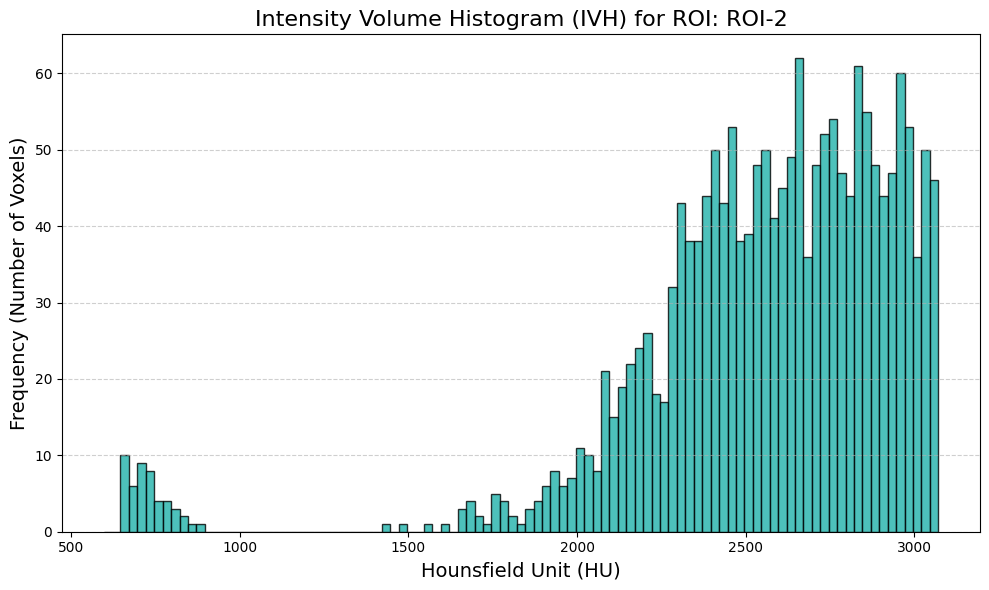

Numerical IVH data for ROI 'ROI-2' saved to CSV: C:\Users\david\Downloads\ivh_roi_ROI-2_data.csv
Overlay visualization saved to: C:\Users\david\Downloads\overlay_slice_124_ROI-2.png


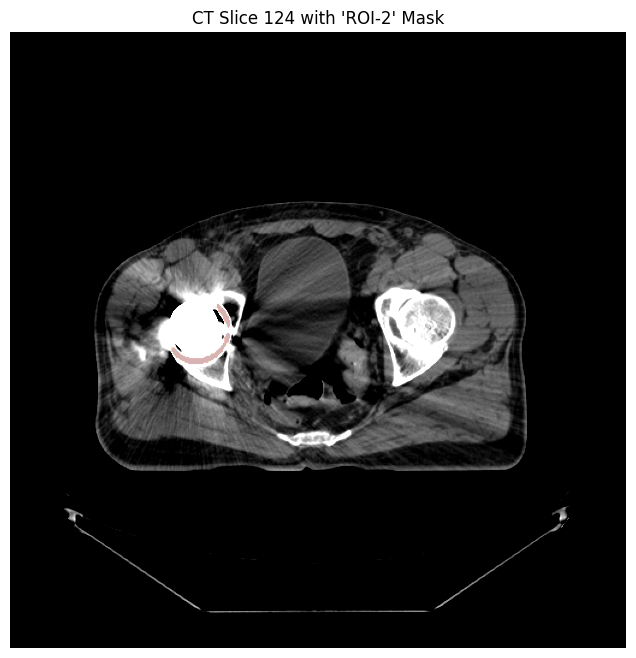

In [50]:
# --- Main Execution Call (how you would use the new function) ---
if __name__ == "__main__":
    # IMPORTANT: REPLACE THESE WITH YOUR ACTUAL PATHS
    ct_series_directory = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"
    rtstruct_file_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 RSTRUCT\2.16.840.1.114362.1.12177026.23360333229.708561731.777.13.dcm"
    
    hip_implant_roi_name = "ROI-2" # Make sure this matches your ROI name exactly

    # Directory where you want to save the output histogram data and plots
    output_save_directory = r"C:\Users\david\Downloads" # Change this to your desired output folder
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_save_directory, exist_ok=True)

    # --- Call the function to generate and save the histogram for the ROI ---
    print("\n--- Generating and Saving IVH for a Specific ROI as CSV ---")
    generate_histogram(ct_series_directory, rtstruct_file_path, hip_implant_roi_name, output_save_directory)